In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
import torchvision.transforms as transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import os
import random
# from google.colab import files
# from zipfile import ZipFile


uploaded = files.upload()
with ZipFile('/content/dataset.zip') as zip:
    zip.extractall()

Saving dataset.zip to dataset.zip


In [ ]:
# path = '/content/not_smoking/anonsmoking0.jpg'
# dataset = []
# dataset.append([torchvision.io.read_image(path).float(), torch.tensor(0.)])
shape = dataset[0][0].shape
names = list(os.walk('/content/dataset/not_smoking'))[0][2]
dataset = []
for i in names:
    path = '/content/dataset/not_smoking/' + i
    dataset.append([torchvision.io.read_image(path).float(), torch.tensor(0.)])
    if dataset[-1][0].shape != shape:
        print(path)
        dataset.pop()

names = list(os.walk('/content/dataset/smoking'))[0][2]
for i in names:
    path = '/content/dataset/smoking/' + i
    dataset.append([torchvision.io.read_image(path).float(), torch.tensor(1.)])
    if dataset[-1][0].shape != shape:
        print(path)
        dataset.pop()

random.seed(1000)
random.shuffle(dataset)

for i in dataset:
    if i[0].shape != dataset[0][0]:
        print('ahhhh')
        break

NameError: ignored

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, img_transform=None, label_transform=None):
        ''' data have format (image, label)'''
        self.data = data
        self.img_t = img_transform
        self.label_t = label_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        if self.img_t:
            data[0] = self.img_t(data[0])
        if self.label_t:
            data[1] = self.label_t(data[1])
        return data

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = "Primary Model"
        self.conv0 = nn.Conv2d(3, 1, 1)
        self.conv1 = nn.Conv2d(1, 2, 3)
        self.conv2 = nn.Conv2d(2, 4, 4)
        self.conv3 = nn.Conv2d(4, 8, 3)
        # self.conv4 = nn.Conv2d(8, 16, 3)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(16 * 12 * 12, 100)
        self.fc2 = nn.Linear(100, 1)

        #self.gapool = nn.AvgPool2d(25)
        #self.fc = nn.Linear(15, 9)

    def forward(self, x):
        x = self.conv0(x)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 16 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.sigmoid(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
def get_loader(data, split, batch, test=False):

    transform = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

    idx = 0
    index = []
    for i in split:
        idx += int(len(data)*i)
        index.append(idx)

    if test:
        dataset = Dataset(data[index[1]:], transform)
        loader = torch.utils.data.DataLoader(
            dataset, batch_size=len(dataset), num_workers=1)
        return loader

    dataset = Dataset(data[:index[0]], transform)
    sampler = SubsetRandomSampler(range(0, len(dataset)))
    train_l = torch.utils.data.DataLoader(
        dataset, batch_size=batch, num_workers=1, sampler=sampler)

    dataset = Dataset(data[index[0]:index[1]], transform)
    sampler = SubsetRandomSampler(range(0, len(dataset)))
    val_l = torch.utils.data.DataLoader(
        dataset, batch_size=len(dataset), num_workers=1)

    return train_l, val_l


def checks(net, sample=0.1, batch=64, lr=0.001, epochs=10):
    '''Sanity checks. Probably just a temporary function'''
    pass

def evaluate(net, loader, criterion):
    loss = 0
    pictures = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data

        outputs = net(inputs)
        # pred = output.max(1, keepdim=True)[1]
        loss = criterion(outputs, labels)
        loss.backward()

        err = (outputs.squeeze().round().int() != labels).sum()
        loss += loss.item()
        pictures += len(labels)
    return err/pictures, loss/(i+1)

def normalize_label(labels):
  max_val = torch.max(labels)
  min_val = torch.min(labels)
  norm_labels = (labels - min_val) / (max_val - min_val)
  return norm_labels

def get_accuracy(model, train_l, val_l, train=False):
    if train:
        data = train_l
    else:
        data = val_l

    total_err = 0.0
    total_epoch = 0
    for imgs, labels in data:

        labels = normalize_label(labels)
        output = model(imgs)

        #select index with maximum prediction score
        # pred = output.max(1, keepdim=True)[1]
        # correct += pred.eq(labels.view_as(pred)).sum().item()
        # total += imgs.shape[0]
        corr = (output > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_epoch += len(labels)

    err = float(total_err) / total_epoch
    acc = float(1-err)

    return acc

Epoch 0 | Error: 0.11181434243917465 | Loss: 0.12539096176624298
Epoch 1 | Training Error: 0.06962025165557861 | Training loss: 0.11656197160482407 | Validation Error: 0.33544304966926575 | Validation loss: 0.4428751468658447 | Training Accuracy: 0.9303797483444214 | Validation Accuracy: 0.6645569801330566
Epoch 2 | Training Error: 0.06329113990068436 | Training loss: 0.1063784584403038 | Validation Error: 0.26582279801368713 | Validation loss: 0.4037291705608368 | Training Accuracy: 0.9367088675498962 | Validation Accuracy: 0.7341772317886353
[tensor(0.1118), tensor(0.0696), tensor(0.0633), tensor(0.0696)] [tensor(0.1254, grad_fn=<DivBackward0>), tensor(0.1166, grad_fn=<DivBackward0>), tensor(0.1064, grad_fn=<DivBackward0>), tensor(0.1045, grad_fn=<DivBackward0>)] [tensor(0.3354), tensor(0.2658), tensor(0.2658)] [tensor(0.4429, grad_fn=<DivBackward0>), tensor(0.4037, grad_fn=<DivBackward0>), tensor(0.3818, grad_fn=<DivBackward0>)]
Epoch 3 | Training Error: 0.06962025165557861 | Traini

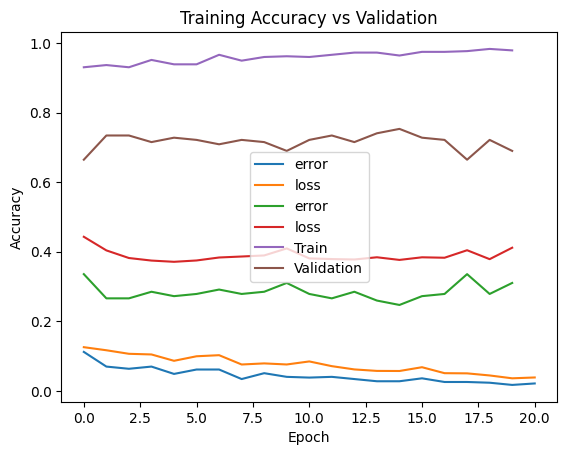

0.24683544039726257
2 395
[tensor([[[[225., 269., 329.,  ..., 191., 161., 143.],
          [199., 239., 297.,  ..., 165., 145., 133.],
          [173., 209., 263.,  ..., 133., 119., 109.],
          ...,
          [229., 231., 235.,  ..., 163., 165., 169.],
          [223., 223., 225.,  ..., 167., 167., 169.],
          [215., 217., 217.,  ..., 159., 159., 159.]],

         [[155., 199., 255.,  ..., 183., 155., 143.],
          [129., 169., 223.,  ..., 157., 139., 133.],
          [107., 139., 189.,  ..., 125., 113., 109.],
          ...,
          [225., 227., 231.,  ..., 161., 163., 167.],
          [219., 219., 221.,  ..., 165., 165., 167.],
          [211., 213., 213.,  ..., 157., 157., 157.]],

         [[143., 187., 243.,  ..., 161., 137., 123.],
          [117., 157., 211.,  ..., 135., 121., 113.],
          [ 97., 131., 177.,  ..., 107.,  99.,  93.],
          ...,
          [227., 229., 233.,  ..., 153., 155., 159.],
          [221., 221., 223.,  ..., 155., 155., 157.],
      

In [ ]:
def train(net, data, split=(0.6,0.2,0.2), name='net', batch=128, lr=0.001, epochs=10):
    global errors_t, losses_t, errors_v, losses_v, accuracy_t, accuracy_v
    accuracy_t = []
    accuracy_v = []
    iter = []
    torch.manual_seed(1000)
    train_l, val_l = get_loader(data, split, batch)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)#, momentum=0.9)

    err_v, loss_v = evaluate(net, train_l, criterion)
    errors_t.append(err_v)
    losses_t.append(loss_v)
    n = 0
    print(f'Epoch 0 | Error: {err_v} |', f'Loss: {loss_v}')
    for epoch in range(epochs):

        loss = 0
        pictures = 0

        for i, data in enumerate(train_l, 0):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            err = (outputs.squeeze().round().int() != labels).sum()
            loss += loss.item()
            pictures += len(labels)


        err_v, loss_v = evaluate(net, val_l, criterion)
        # current_train_acc = get_accuracy(net, train_l, val_l, train=True)
        # current_val_acc = get_accuracy(net, train_l, val_l, train=False)
        # accuracy_t.append(current_train_acc)
        # accuracy_v.append(current_val_acc)
        current_train_acc = 1 - err/pictures
        current_val_acc = 1 - err_v
        accuracy_t.append(current_train_acc)
        accuracy_v.append(current_val_acc)
        errors_t.append(err/pictures)
        losses_t.append(loss/(i+1))
        errors_v.append(err_v)
        losses_v.append(loss_v)
        iter.append(n)
        n += 1
        if epoch == 2:
            print(errors_t, losses_t, errors_v, losses_v)
        print(f'Epoch {epoch+1} | Training Error: {err/pictures} |',
              f'Training loss: {loss/(i+1)} | Validation Error: {err_v} |',
              f'Validation loss: {loss_v} | Training Accuracy: {current_train_acc} |',
              f'Validation Accuracy: {current_val_acc}')
        model_path = "model_{}_bs_{}_lr{}epoch{}".format(name, batch, lr, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')

errors_t = []
losses_t = []
errors_v = []
losses_v = []
model = Net()
train(model, dataset, split=(0.6,0.2,0.2), batch=128, lr=0.0005, epochs=20)

# plt.title("Train Error vs Loss")
# e1 = [i.item() for i in errors_t]
# l1 = [i.item() for i in losses_t]
# plt.plot(e1, label="error")
# plt.plot(l1, label='loss')
# plt.xlabel("Epoch")
# plt.legend(loc='best')

# plt.title("Validation Error vs Loss")
# e2 = [i.item() for i in errors_v]
# l2 = [i.item() for i in losses_v]
# plt.plot(e2, label="error")
# plt.plot(l2, label='loss')
# plt.xlabel("Epoch")
# plt.legend(loc='best')

plt.title("Training Accuracy vs Validation")
e1 = [i.item() for i in accuracy_t]
l1 = [i.item() for i in accuracy_v]
plt.plot(e1, label="Train")
plt.plot(l1, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

#for i in Net().parameters():
 #   print(i)
print(min(e2))
sum(p.numel() for p in Net().parameters() if p.requires_grad)


## I can't remember what this is for so I'm keeping this here for now
random.shuffle(dataset)
train_l, val_l = get_loader(dataset, (0.9,0.1,0.2), 128)
#evaluate(Net(), train_l, nn.MSELoss())
train_l, val_l = get_loader(dataset, (0.0,0.5,0.2), 1)
train_l2, val_l2 = get_loader(dataset, (0.5,1.0,0.2), 1)
a = []
b = []
for i in val_l:
    for j in i:
        a.append(j)
for i in train_l2:
    b.append(i)
print(len(a), len(b))
print(a)

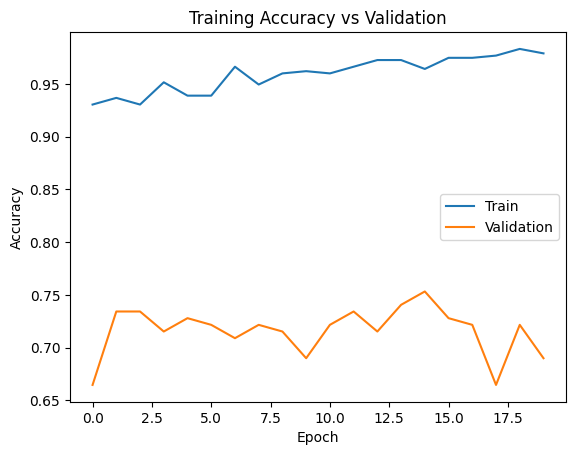

In [ ]:
plt.title("Training Accuracy vs Validation")
e1 = [i.item() for i in accuracy_t]
l1 = [i.item() for i in accuracy_v]
plt.plot(e1, label="Train")
plt.plot(l1, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

In [ ]:
# transform = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
from PIL import Image

train_l, val_l = get_loader(dataset, split=(0.6,0.2,0.2), batch=128)
image = Image.open("/content/dataset/smoking/smoking0.jpg")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Assuming normalization was applied during training
])
img = transform(image)
img = img.unsqueeze(0)


model = Net()
model_path = "model_{0}_bs_{1}_lr{2}epoch{3}".format('net', 128, 0.0005, 19)
state = torch.load(model_path)
model.load_state_dict(state)
model.eval()

output = model(img)
print(output.data)

#print("Probability of not smoking:", probabilities)
# for i, data in enumerate(train_l, 0):
#     model.eval()\
#     inputs, labels = data
#     outputs = model(inputs)
#     prob = torch.nn.functional.softmax(outputs[0], dim=0)
#     # probs = F.softmax(outputs, dim=1)
#     # not_smoking_prob = probs[0][0].item()
#     #_, predicted = torch.max(outputs, 1)
#     #prob = nn.Softmax(outputs)
#     #prob = F.softmax(outputs, dim=1)
#     #print('output: ', prob.max(1, keepdim=True)[1].item(), 'with a probability of', prob.max(1, keepdim=True)[0].item())
#     print(prob)
#     break

tensor([0.2965])
